# Computer Vision Analysis
#### By Ronny Toribio, Kadir O. Altunel, Michael Cook-Stahl
#### Based on [Hands on Machine Learning 2nd edition](https://github.com/ageron/handson-ml2/) and [FER2013](https://www.kaggle.com/code/ritikjain00/model-training-fer-13)

### Import modules and declare constants

In [1]:
%matplotlib inline
import os.path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

BATCH_SIZE = 32
INPUT_SHAPE = (48, 48, 1)

### Load Facial Emotion Recognition dataset
#### training, validation, and testing

In [2]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, horizontal_flip=True, validation_split=0.10)
Xy_train = train_datagen.flow_from_directory(os.path.join("fer2013", "train"), batch_size=BATCH_SIZE, 
                                          target_size=(48, 48), shuffle=True, subset="training",
                                          color_mode="grayscale", class_mode="categorical")

Xy_valid = train_datagen.flow_from_directory(os.path.join("fer2013", "train"), batch_size=BATCH_SIZE, 
                                          target_size=(48, 48), shuffle=True, subset="validation",
                                          color_mode="grayscale", class_mode="categorical")

test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3)
Xy_test = test_datagen.flow_from_directory(os.path.join("fer2013", "test"), batch_size=BATCH_SIZE,
                                          target_size=(48, 48), shuffle=True,
                                          color_mode="grayscale", class_mode="categorical")

Found 25841 images belonging to 7 classes.
Found 2868 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Build CNN model

In [3]:
model = Sequential([
    # Convolution Block 1
    Conv2D(32, kernel_size=(3, 3), padding="same", activation="relu", input_shape=INPUT_SHAPE),
    Conv2D(64, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"),
    Dropout(0.25),
    
    # Convolution Block 2
    Conv2D(128, kernel_size=(3, 3), padding="same", activation="relu", kernel_regularizer=l2(0.01)),
    Conv2D(256, kernel_size=(3, 3), padding="valid", activation="relu", kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2), padding="valid"),
    Dropout(0.25),
    
    # Classification Block
    Flatten(),
    Dense(1024, activation="relu"),
    Dropout(0.5),
    Dense(7, activation="softmax")
])

### Model properties

In [4]:
model.layers

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       7

In [6]:
# requires pydot and graphviz modules
plot_model(model, "cnn_model.png", show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


### Compile model

In [7]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.0001, decay=1e-6),
              metrics=["accuracy"])

### Checkpoint callback

In [8]:
checkpoint_cb = ModelCheckpoint("cnn_model.h5", save_best_only=True)

### Early stopping callback

In [9]:
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

### Reduce learning rate on plateau callback

In [10]:
reduce_lr_cb = ReduceLROnPlateau(patience=3, factor=0.1)

### Train the model

In [11]:
history = model.fit(Xy_train, epochs=60, validation_data=(Xy_valid),
                    steps_per_epoch=Xy_train.n // BATCH_SIZE,
                    validation_steps=Xy_valid.n // BATCH_SIZE,
                    callbacks=[checkpoint_cb, early_stopping_cb, reduce_lr_cb])

Epoch 1/60
807/807 [==============================] - 195s 240ms/step - loss: 4.1971 - accuracy: 0.2803 - val_loss: 3.6188 - val_accuracy: 0.3662 - lr: 1.0000e-04
Epoch 2/60
807/807 [==============================] - 195s 241ms/step - loss: 3.2840 - accuracy: 0.3441 - val_loss: 2.8889 - val_accuracy: 0.3873 - lr: 1.0000e-04
Epoch 3/60
807/807 [==============================] - 195s 242ms/step - loss: 2.6705 - accuracy: 0.3827 - val_loss: 2.3875 - val_accuracy: 0.4161 - lr: 1.0000e-04
Epoch 4/60
807/807 [==============================] - 194s 241ms/step - loss: 2.2235 - accuracy: 0.4195 - val_loss: 2.0350 - val_accuracy: 0.4459 - lr: 1.0000e-04
Epoch 5/60
807/807 [==============================] - 194s 241ms/step - loss: 1.9221 - accuracy: 0.4412 - val_loss: 1.7786 - val_accuracy: 0.4642 - lr: 1.0000e-04
Epoch 6/60
807/807 [==============================] - 193s 239ms/step - loss: 1.7080 - accuracy: 0.4696 - val_loss: 1.6016 - val_accuracy: 0.4860 - lr: 1.0000e-04
Epoch 7/60
807/807 [==

### Roll back to the best model

In [12]:
model = load_model("cnn_model.h5")

### Plot training history

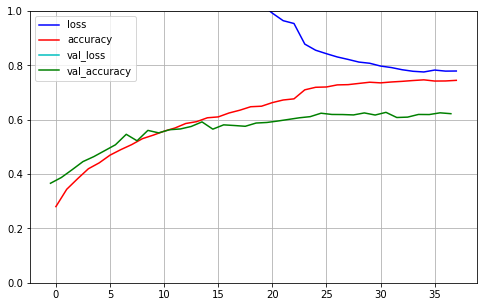

In [17]:
adjusted_epoch = [x - 0.5 for x in history.epoch]
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.grid(True)
ax.plot(history.epoch, history.history["loss"], "b-", label="loss")
ax.plot(history.epoch, history.history["accuracy"], "r-", label="accuracy")
ax.plot(adjusted_epoch, history.history["val_loss"], "c-", label="val_loss")
ax.plot(adjusted_epoch, history.history["val_accuracy"], "g-", label="val_accuracy")
ax.legend()
fig.savefig("cnn_model_training.png")
plt.show()

### Evaluate model

In [18]:
model.evaluate(Xy_test)

225/225 [==============================] - 9s 38ms/step - loss: 1.0927 - accuracy: 0.6443


[1.0927475690841675, 0.6443299055099487]

### Save weights

In [16]:
model.save_weights("cnn_model_weights.ckpt")